Test acc: 1.0
shap_values type: <class 'numpy.ndarray'>
shap_values shape: (45, 4, 3)
combined shap_2d shape: (45, 4)


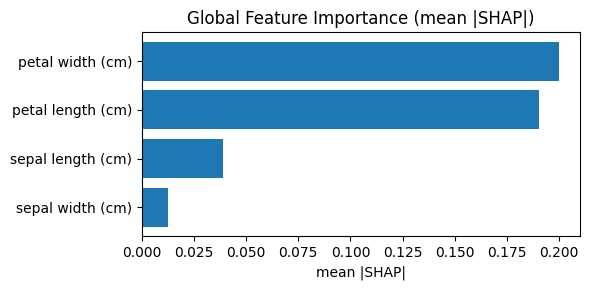

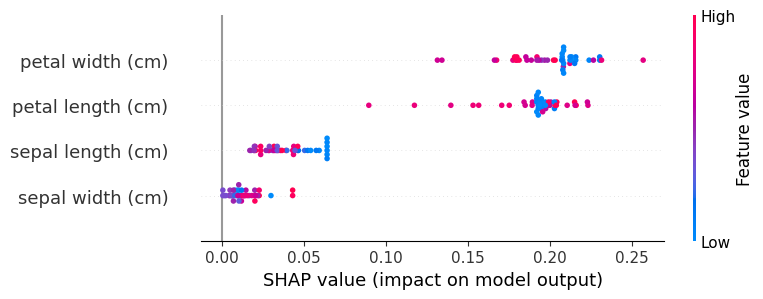

In [ ]:
import shap, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Test acc:", model.score(X_test, y_test))

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)   # returned as ndarray shape (n_samples, n_features, n_classes) in your run

print("shap_values type:", type(shap_values))
print("shap_values shape:", np.shape(shap_values))

# --- Combine to 2D ---
# If shap_values is a list (one array per class) -> stack then average abs across classes
# If it's a 3D ndarray with class axis last -> take mean(abs, axis=2) to collapse class axis
if isinstance(shap_values, list):
    stacked = np.stack(shap_values, axis=2)    # shape (n_samples, n_features, n_classes)
    shap_2d = np.mean(np.abs(stacked), axis=2) # shape (n_samples, n_features)
elif isinstance(shap_values, np.ndarray):
    if shap_values.ndim == 3:
        shap_2d = np.mean(np.abs(shap_values), axis=2)
    elif shap_values.ndim == 2:
        shap_2d = np.abs(shap_values)
    else:
        raise ValueError("Unexpected shap_values ndim: " + str(shap_values.ndim))
else:
    raise ValueError("Unexpected type for shap_values")

print("combined shap_2d shape:", shap_2d.shape)
assert shap_2d.shape[1] == X_test.shape[1]

# 1) Bar plot: global importance (mean |SHAP|)
mean_abs = shap_2d.mean(axis=0)
imp_df = pd.DataFrame({"feature": X_test.columns, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
plt.figure(figsize=(6,3))
plt.barh(imp_df['feature'], imp_df['mean_abs_shap'])
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (mean |SHAP|)")
plt.xlabel("mean |SHAP|")
plt.tight_layout()
plt.show()

# 2) Beeswarm (summary) using 2D SHAP and explicit feature names
shap.summary_plot(shap_2d, X_test.values, feature_names=X_test.columns, show=True)
